In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
from os import path
import matplotlib.ticker as ticker
from scipy import stats
from sklearn.linear_model import LinearRegression

labels = ["paiceHusk", "krovetz", "sStripping", "porter2", "lovins", "wikt", "none"]
labels_title = ["Paice/Husk", "Krovetz", "S-Stripping", "Porter2", "Lovins", "Wikt", "None"]
maxLengths = [20,55,148,403,1097,2981,2000000] #may need to update largest length

home_dir = "/home/harka424/Documents/COSC490/Stemming"
data_dir_clueweb = path.join(home_dir, "Data/clueweb")
data_dir_wikt = path.join(home_dir, "Data/wikt")

MARKERS = ["o","^","s","*","d", "P", "X"]
markers = itertools.cycle(MARKERS)

In [2]:
SMALL_SIZE = 11
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Preparing Data

In [3]:
df_list = list()

for l in maxLengths:
   df = pd.read_csv(path.join(data_dir_clueweb,f"documentLength/ndcg_{l}"), sep=" ")
   df_list.append(df)

data = pd.concat(df_list, ignore_index=True)

data_avg = data[data["qid"] == "amean"]
data = data.drop(data[data["qid"] == "amean"].index)

### Overall nDCG

In [21]:
target_data = data_avg

best_nDCG = list()
for length in maxLengths:
    selected_data = data_avg[data_avg["maxLength"] == length]
    best_nDCG.append(selected_data["ndcg"].max())

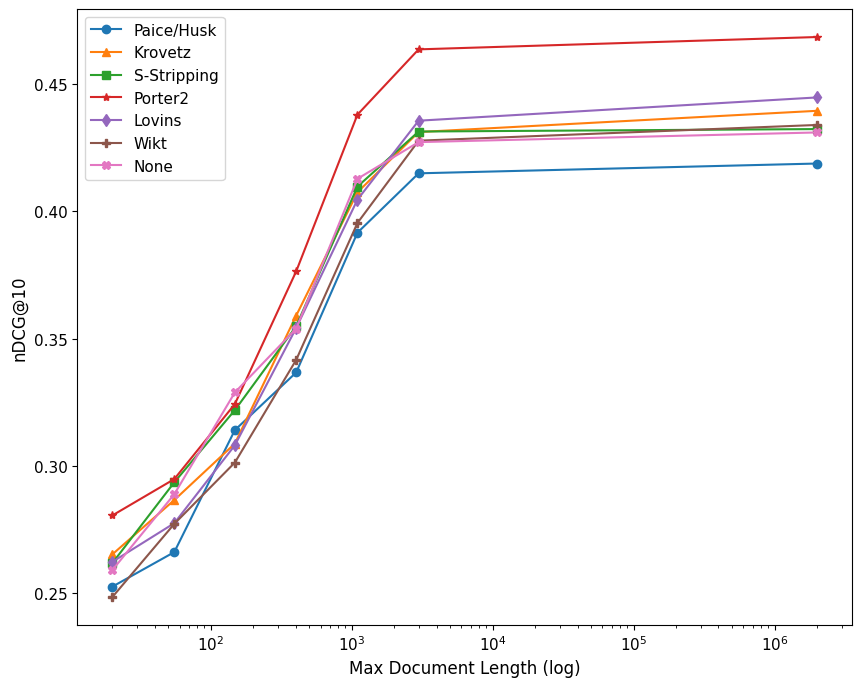

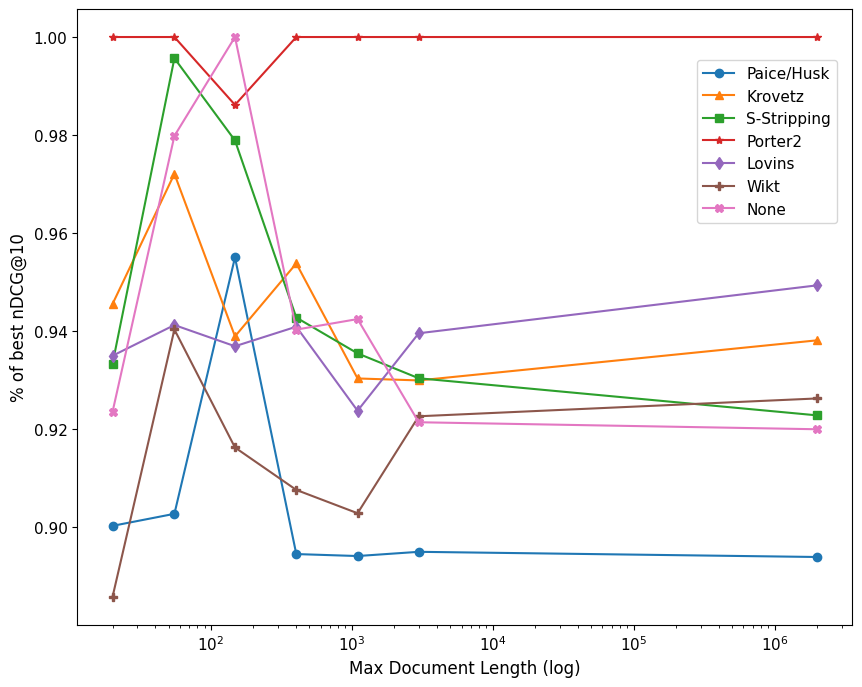

In [14]:
plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = target_data[target_data["stemmer"] == stemmer]
    plt.plot(stemmer_data["maxLength"], stemmer_data["ndcg"], marker=next(markers), label=stemmer)
    plt.xscale("log")

# plt.title("nDCG@10 vs Document Length")
plt.xlabel("Max Document Length (log)")
plt.ylabel("nDCG@10")
plt.legend(labels=labels_title)
plt.show()

# ----------------------------------------------------------------------

plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = target_data[target_data["stemmer"] == stemmer]
    stemmer_values = np.array(stemmer_data["ndcg"])/best_nDCG
    plt.plot(stemmer_data["maxLength"], stemmer_values, marker=next(markers), label=stemmer)
    plt.xscale("log")
# plt.title("nDCG@10 vs Document Length")
plt.xlabel("Max Document Length (log)")
plt.ylabel("% of best nDCG@10")
plt.legend(bbox_to_anchor=(0.99,0.93),labels=labels_title)
plt.show()

### Linguistic Accuracy

In [4]:
ndcg_fmeasure = data_avg[data_avg["stemmer"] != "none"]
ndcg_fmeasure = ndcg_fmeasure[ndcg_fmeasure["stemmer"] != "wikt"]
averages = list()
for stemmer in labels[:-2]:
    fmeasures = np.loadtxt(path.join(data_dir_wikt,f"{stemmer}_cluster_fmeasures.csv"))
    averages.append(fmeasures.mean())
fmeasures = list()
for length in maxLengths:
    fmeasures.extend(averages)
ndcg_fmeasure = ndcg_fmeasure.assign(fmeasure=fmeasures)

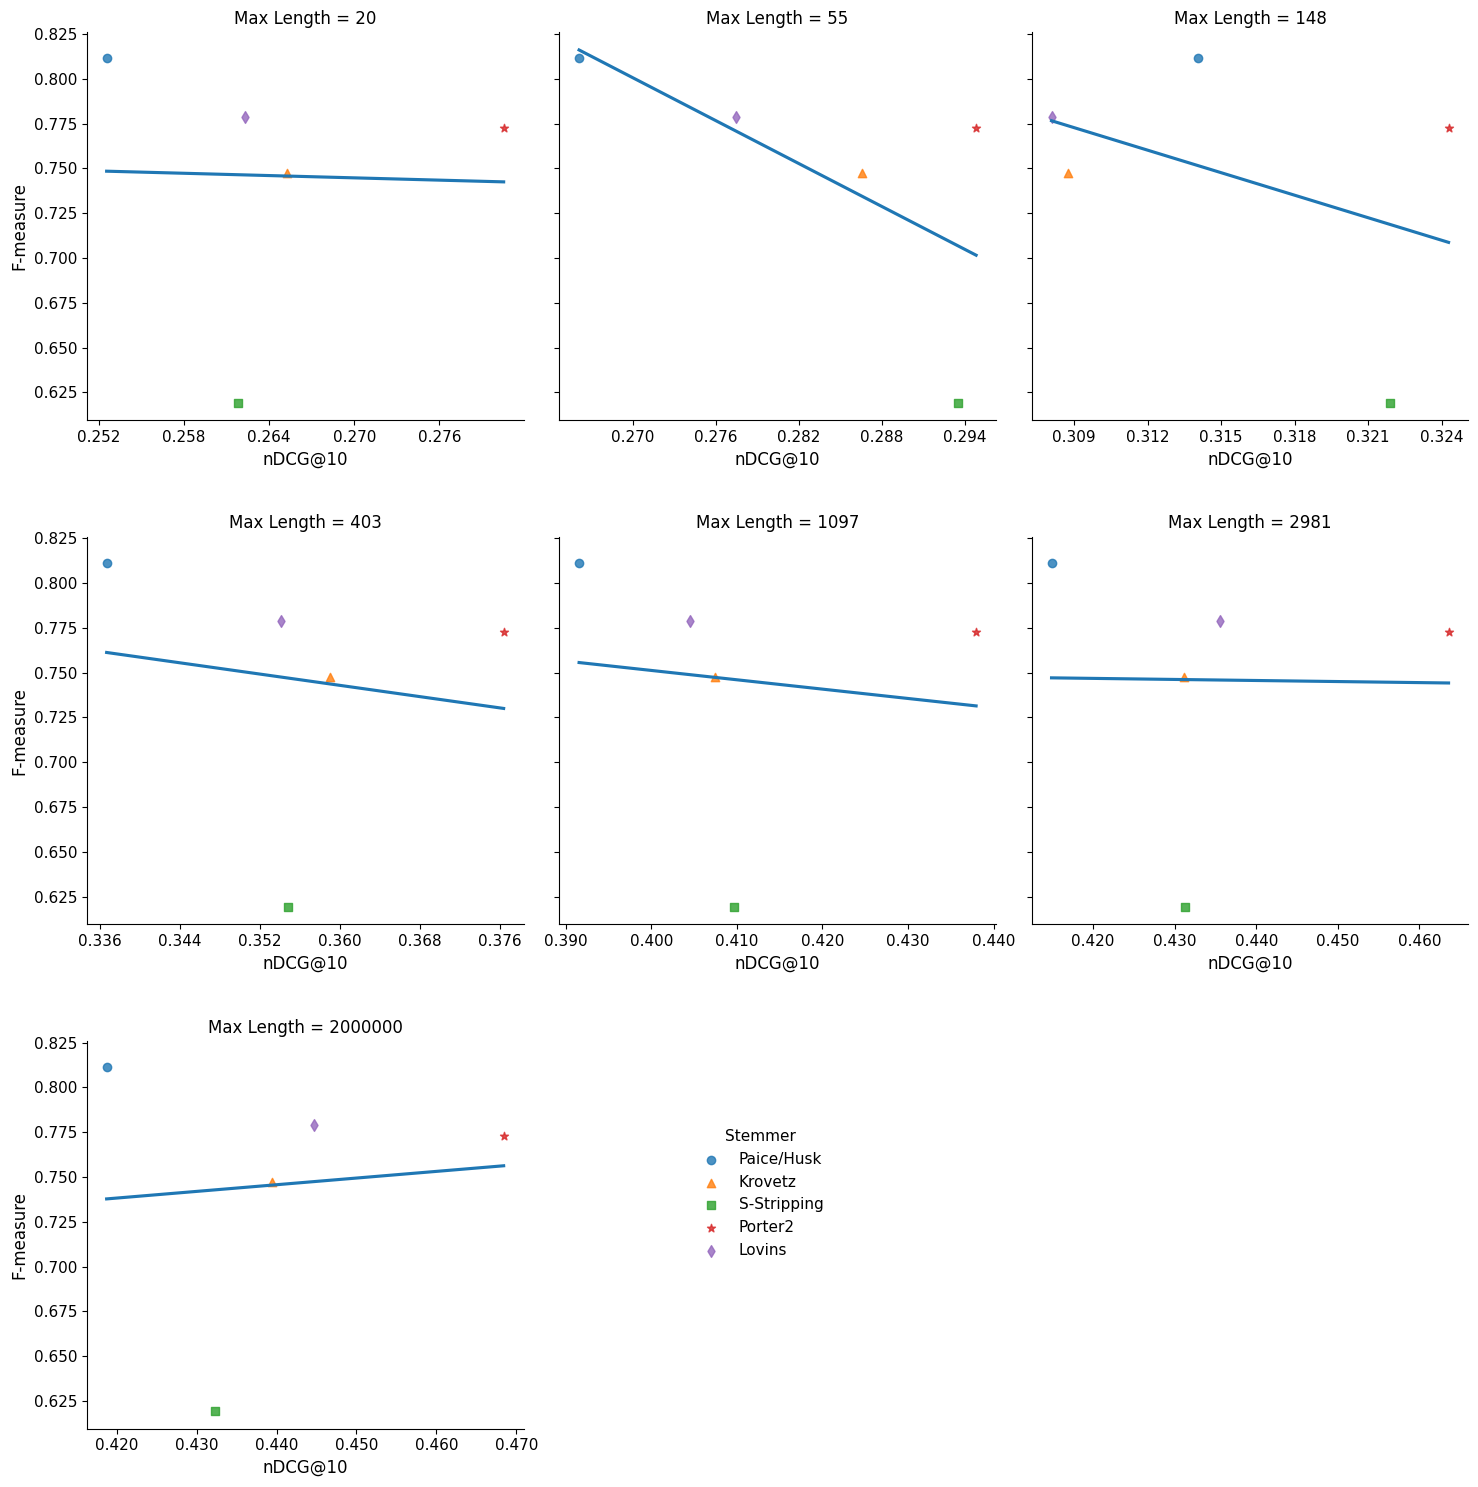

In [7]:
graph = sns.lmplot(ndcg_fmeasure, x="ndcg", y="fmeasure", hue="stemmer", markers=MARKERS[:-2], col="maxLength", col_wrap=3, facet_kws={"sharex": False}, fit_reg=False, legend=False)
graph.set_titles(col_template="Max Length = {col_name}")

for document_length, ax in zip(np.unique(data_avg["maxLength"]), graph.axes):
    target_data = ndcg_fmeasure[ndcg_fmeasure["maxLength"] == document_length]
    sns.regplot(target_data, x="ndcg", y="fmeasure", scatter=False, ci=None, ax=ax)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(6))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%0.3f"))
graph.set(ylabel="F-measure",xlabel="nDCG@10")
graph.add_legend(title="Stemmer",labels=labels_title[:-2],bbox_to_anchor=(0.52,0.2))
plt.subplots_adjust(hspace=0.3)
plt.show()

In [8]:
print("length pearson-R p-value")
for length in maxLengths:
    x = ndcg_fmeasure[ndcg_fmeasure["maxLength"] == length]["ndcg"].to_numpy()
    y = ndcg_fmeasure[ndcg_fmeasure["maxLength"] == length]["fmeasure"].to_numpy()
    print(f"{length} {stats.pearsonr(x,y).statistic:.3f} {stats.pearsonr(x,y).pvalue:.3f}")

length pearson-R p-value
20 -0.029 0.963
55 -0.644 0.241
148 -0.419 0.483
403 -0.150 0.810
1097 -0.119 0.848
2981 -0.014 0.982
2000000 0.092 0.884


### Statistical Significance

In [9]:
#t-test between the porter2 stemmer (one of the best performing) and no stemming
print("length t-statistic p-value")
for length in maxLengths:
    s = list()
    n = list()
    target_data = data[data["maxLength"] == length]
    s = target_data[target_data["stemmer"] == "porter2"].loc[:,"ndcg"].tolist()
    n = target_data[target_data["stemmer"] == "none"].loc[:,"ndcg"].tolist()
    print(f"{length} {stats.ttest_rel(s,n).statistic:.4f} {stats.ttest_rel(s,n).pvalue:.4f}")

length t-statistic p-value
20 1.7666 0.0804
55 0.4383 0.6621
148 -0.3188 0.7506
403 1.3126 0.1923
1097 1.5445 0.1257
2981 2.0878 0.0394
2000000 2.1703 0.0324


In [10]:
#t-test between paiceHusk and none
print("length t-statistic p-value")
for length in maxLengths:
    s = list()
    n = list()
    target_data = data[data["maxLength"] == length]
    s = target_data[target_data["stemmer"] == "paiceHusk"].loc[:,"ndcg"].tolist()
    n = target_data[target_data["stemmer"] == "none"].loc[:,"ndcg"].tolist()
    print(f"{length} {stats.ttest_rel(s,n).statistic:.4f} {stats.ttest_rel(s,n).pvalue:.4f}")

length t-statistic p-value
20 -0.5605 0.5764
55 -1.5782 0.1177
148 -1.1461 0.2545
403 -1.1477 0.2538
1097 -1.2212 0.2249
2981 -0.5994 0.5503
2000000 -0.6123 0.5417


In [11]:
#t-test between porter2 and paiceHusk
print("length t-statistic p-value")
for length in maxLengths:
    s = list()
    n = list()
    target_data = data[data["maxLength"] == length]
    s = target_data[target_data["stemmer"] == "porter2"].loc[:,"ndcg"].tolist()
    n = target_data[target_data["stemmer"] == "paiceHusk"].loc[:,"ndcg"].tolist()
    print(f"{length} {stats.ttest_rel(s,n).statistic:.4f} {stats.ttest_rel(s,n).pvalue:.4f}")

length t-statistic p-value
20 2.2190 0.0288
55 2.0680 0.0412
148 0.9252 0.3571
403 2.6975 0.0082
1097 2.7216 0.0077
2981 2.6543 0.0093
2000000 2.6539 0.0093


In [12]:
#t-test between wikt and none
print("length t-statistic p-value")
for length in maxLengths:
    s = list()
    n = list()
    target_data = data[data["maxLength"] == length]
    s = target_data[target_data["stemmer"] == "wikt"].loc[:,"ndcg"].tolist()
    n = target_data[target_data["stemmer"] == "none"].loc[:,"ndcg"].tolist()
    print(f"{length} {stats.ttest_rel(s,n).statistic:.4f} {stats.ttest_rel(s,n).pvalue:.4f}")

length t-statistic p-value
20 -0.8635 0.3900
55 -0.9712 0.3338
148 -2.1207 0.0364
403 -0.7659 0.4455
1097 -1.1641 0.2472
2981 0.0310 0.9753
2000000 0.1719 0.8639
